# UCSanDiegoX: DSE200x
## Python for Data Science : Analysis of The Used Cars Dataset (Kaggle)
Samuel Quiroga (April-August 2020)

### Project Overview

In this final project of the Python for Data Science Course, I will look at the Used Cars Dataset from Craigslist. The data is available on _Kaggle_ (link [here](https://www.kaggle.com/austinreese/craigslist-carstrucks-data])) and it consists of vehicles sale listings from the website Craigslist.com.

### Research Question

Can the price of a vehicle be predicted from this dataset using a Decision Tree Regressor?


### Executive Summary

The purpose of the analysis was to perform a **decision tree regression model** on the dataset to predict the `price` variable. Here is a summary of the steps involved: 

- Only colums that contained at least %70 of non-Null values were kept
- Outliers and non-NA values were removed from the dataset
- Variables used for the prediction model are: `drive`,`type`,`title_status`,`fuel`, `transmission`,`odometer`,`year`, and `price`
- Some categorical values were merged due to ambiguity (e.g. `vehicle type` 'truck' vs 'pickup')
- Categorical variables were hot-encoded (0 and 1)
- Randomized Search Cross-Validation was performed on the regressor model to obtain a better fit but there was no significant improvement on the prediction accuracy
- The best prediction model attained a **%75** prediction accuracy with the following decision tree parameters:

    `Mean validation score: 0.755 (std: 0.002)`
    
    `Parameters: {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 14, 'criterion': 'mse'}`
    
### Analysis Limitations
There are some possible limitations to the analysis:

- A large number of levels in the categorical variables were used in this dataset, which could have impacted the model performance by over-fitting it (hense the high test error rate).
- The locaion information (lat/long, state) was not used in this analysis but could have added more information.

### Further Improvement

Some more work is required to improve the mode accuracy. A few things that could be done:
- Trying reducing the number of levels in the categorical variables.
- Exploring a simpler multi-linear model that only uses numerical data (`price`, `odometer`, and `year`). 
- Exploring a more complex model, such as Random Forests to increase the level of accuracy.

In [6]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load regression libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

## Import and read dataset

First, look for the downloaded file from https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download.

In [2]:
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

craigslist-carstrucks-data.zip



Unzip the file and extract into the data folder.

In [3]:
# how to from https://www.kaggle.com/mchirico/how-to-read-datasets
import zipfile
Dataset = "craigslist-carstrucks-data"

with zipfile.ZipFile("./data/"+Dataset+".zip","r") as z:
     z.extractall("./data")

Import data as pandas dataframe.

In [7]:
cars_raw = pd.read_csv("./data/vehicles.csv")

In [5]:
# dataframe shape
print("Number of rows:",cars_raw.shape[0])
print()
print("Number of columns",cars_raw.shape[1])

Number of rows: 539759

Number of columns 25


## Preliminary Data Cleaning

Remove unnecessary columns and null values. Let's look at the proportion of non-null values as percent of total number of rows. This will give us an idea of which variables contain the most amount of actual data vs those that are mostly `NULL`.

In [9]:
no_null_prc = (cars_raw.count()/len(cars_raw)).round(2)*100
no_null_prc

id              100.0
url             100.0
region          100.0
region_url      100.0
price           100.0
year            100.0
manufacturer     96.0
model            99.0
condition        56.0
cylinders        60.0
fuel             99.0
odometer         82.0
title_status     99.0
transmission     99.0
vin              58.0
drive            71.0
size             31.0
type             73.0
paint_color      68.0
image_url       100.0
description     100.0
county            0.0
state           100.0
lat              98.0
long             98.0
dtype: float64

Select columns of interest that have greater than 70% of actual data (no-NULL values).

In [10]:
cols_to_use = list(no_null_prc[no_null_prc>=70].index)
cols_to_use

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'type',
 'image_url',
 'description',
 'state',
 'lat',
 'long']

Remove columns that will not be used further in the analysis: these columns only contain the `id` and other `url` information. We also remove `description`, `image_url`, and `location` information. We also remove the `model` and `manufacturer` columns.

In [11]:
cols_not_needed = list(cars_raw.columns[0:4])
cols_not_needed.extend(['description','image_url','state','lat','long','manufacturer','model'])
cols_not_needed

['id',
 'url',
 'region',
 'region_url',
 'description',
 'image_url',
 'state',
 'lat',
 'long',
 'manufacturer',
 'model']

Lastly, we remove any `na` values and select our features of interest

In [12]:
cars = cars_raw[[name for name in cols_to_use if name not in cols_not_needed]]
cars = cars.dropna()
cars.sample(10)

,price,year,fuel,odometer,title_status,transmission,drive,type
326468,14995,2011.0,gas,130042.0,clean,automatic,4wd,SUV
13852,0,2013.0,gas,129200.0,clean,automatic,4wd,SUV
173796,1,2016.0,gas,47139.0,clean,other,4wd,truck
399223,22470,2016.0,gas,36717.0,clean,automatic,4wd,SUV
403954,21985,2017.0,gas,30016.0,clean,automatic,rwd,coupe
525205,18998,2013.0,gas,130923.0,clean,automatic,4wd,truck
274230,22900,2015.0,gas,77104.0,clean,other,4wd,pickup
235530,18600,2018.0,gas,18400.0,clean,other,fwd,other
489156,39700,2017.0,diesel,56774.0,clean,automatic,4wd,pickup
161041,4000,2006.0,gas,114700.0,clean,automatic,rwd,coupe


### Description of the variables:

Here is a breakdown of the variables and their types.

Categorical variables:
- drive
- type
- fuel
- title_status
- transmission

Numerical variables:
- price
- odometer

Date variables:
- year

In [13]:
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 302911

Number of columns 8


## Preliminary data exploration and further cleaning

We will now explore the data and determine what further cleaning needs to be done. First, lets look at the distribution of the numeric variables, here is a summary of the median data : 

- Median price is $10,990 while the max value is 4.2 billion dollars!
- Median odometer reading is 94674 mi.
- Median year is 2012

Here are some more additiona statistics.

In [14]:
cars.describe(percentiles=[0.05,0.1,0.5,0.9,0.95]).transpose()

,count,mean,std,min,5%,10%,50%,90%,95%,max
price,302911.0,191389.370987,2.333448e+07,0.0,0.0,900.0,10990.0,28000.0,34900.0,4.198287e+09
year,302911.0,2010.844987,7.058727e+00,1900.0,2000.0,2003.0,2012.0,2017.0,2018.0,2.021000e+03
odometer,302911.0,100539.526382,1.132707e+05,0.0,12933.0,23581.0,93674.0,179000.0,205000.0,1.000000e+07


### Price and Odometer

Remove vehicles with prices and odometer readings that are slightly more than the 90% percentile and less than the 1% percentile. This will get rid of extreme outliers. We will also remove `year` values equal to zero. 

In [12]:
cars = cars[(cars.price<=30000) & 
              (cars.price>1000) & 
              (cars.odometer<=180000) &  
              (cars.odometer>=2000) & 
              (cars.year > 0)]

# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 217652

Number of columns 8


Let's look at a plot of a joint histogram using exagonal bins of the price with odometer reading: notice the downward non-linear nature of of the data.

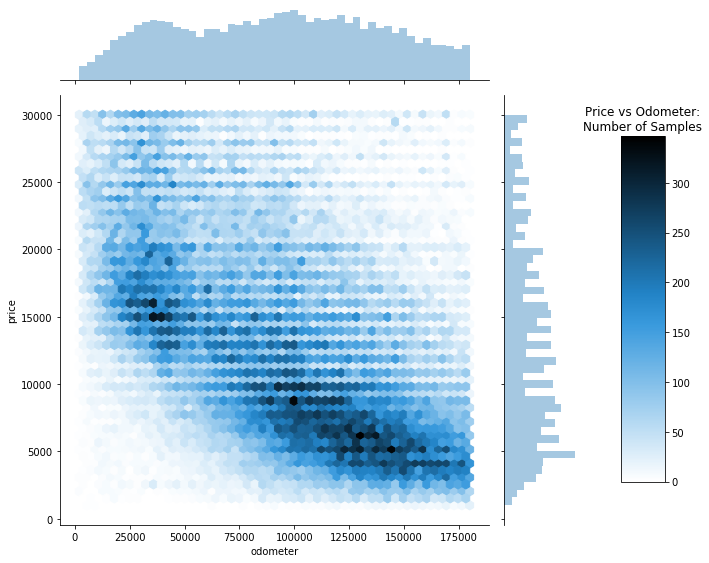

In [13]:
# how to add legend from https://stackoverflow.com/questions/29096632/getting-legend-in-seaborn-jointplot/29909033
hexplot = sns.jointplot("odometer", "price", data=cars,height=12,kind = "hex");
cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
plt.colorbar(cax=cbar_ax)
plt.title('Price vs Odometer:\nNumber of Samples')
plt.show()

### Transmission

Now let's look a the `transmission` type. A large majority of values in transmission are laballed as  "other":

In [14]:
cars.transmission.value_counts()

automatic    192228
other         13120
manual        12304
Name: transmission, dtype: int64

We'll assume transmission labeled "other" is automatic:

In [15]:
cars['transmission'] = np.where(cars.transmission == "other","automatic",cars.transmission)

Now let's look at the boxplot of transmission type vs price. Notice that vehicles with an automatic transmission tend to be at slightly higher price:

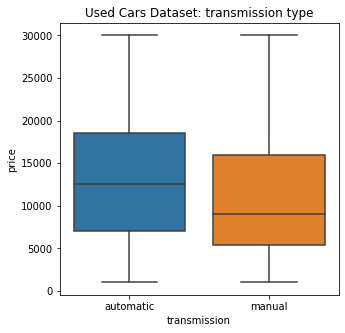

In [16]:
plt.figure(figsize=(5,5))
sns.boxplot(x='transmission',y='price',data=cars).set_title('Used Cars Dataset: transmission type');

### Title Status

A very small number of listings of `title_status` values are either labeled "missing" or "parts only". So we'll remove those variables from the dataset.

In [17]:
cars.title_status.value_counts()

clean         207502
rebuilt         6372
salvage         2217
lien            1455
missing           85
parts only        21
Name: title_status, dtype: int64

In [18]:
# remove 'missing' and 'parts only'
keep = ['clean','rebuilt','salvage','lien']
cars = cars[cars['title_status'].isin(keep)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 217546

Number of columns 8


Now let's look a the boxplot of `titlestatus` vs `price`. Interestingly, vehicles with a lien tend to be higher priced. This could be because those vehicles typically are being sold to pay off creditors (banks, dealerships, etc.)

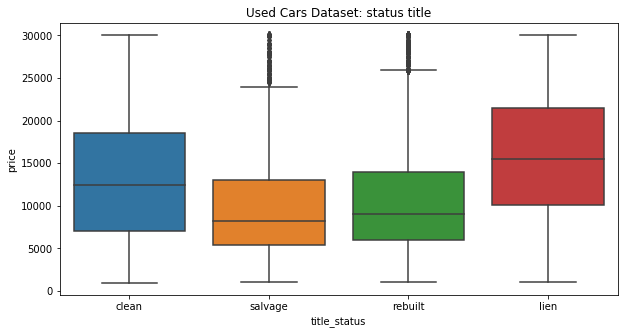

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x='title_status',y='price',data=cars).set_title('Used Cars Dataset: status title');

### Fuel Type

Let's take a look at the distribution of `prices` by `fuel` type: notice that diesel-powered vehicles tend to be more expensive, while hybrid-types are the cheapest. Note, however, that diesel-powered vehicles could also be larger in general (Think trucks and SUV's), which makes them more expensive.

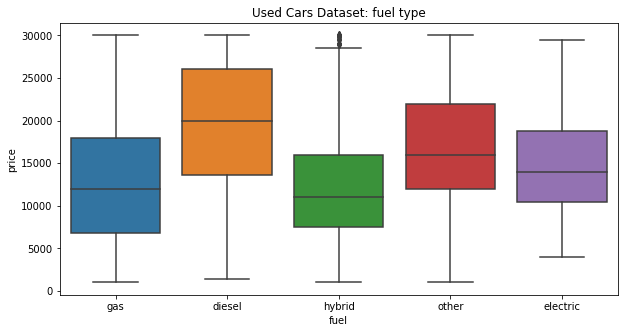

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(x='fuel',y='price',data=cars).set_title('Used Cars Dataset: fuel type');

Vehicles with fuel type as  "other" can be removed from the analysis since it would be difficult to identify the fuel type to for those vehicles:

In [21]:
cars.fuel.value_counts()

gas         199815
diesel        9689
other         5315
hybrid        2268
electric       459
Name: fuel, dtype: int64

In [22]:
# remove fuel type "other"
cars = cars[~cars['fuel'].isin(['other'])]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 212231

Number of columns 8


### Year

Lets see the number of vehicles grouped by `year` on a line plot: notice that most vehicles listings are for vehicles of years between the late 90's and early 2020.

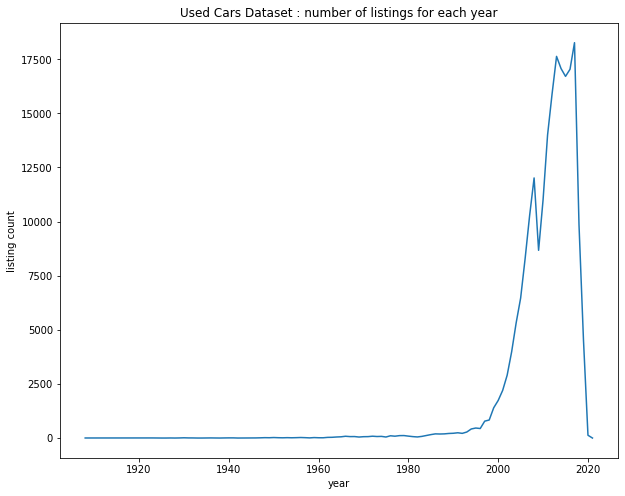

In [23]:
grouped_by_year = cars.groupby('year').count().reset_index()
plt.figure(figsize=(10,8))
ax = sns.lineplot(x='year',y='price',data=grouped_by_year);
ax.set(ylabel="listing count",title='Used Cars Dataset : number of listings for each year');

For this analysis we'll look at listings between 1999 and 2019:

In [24]:
cars = cars[(cars.year>=1999) & (cars.year<=2019)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 205263

Number of columns 8


## Vehicle Type

Let's now look at vehicle type. There are quite a few types of vehicles in the data set. However, there are some types that do not occur very often ("bus", "off-road") and other types that could refer to the same vehicle type ("pickup" and "truck", which interestingly have very similar distributions, making it very possible that those are the same type).

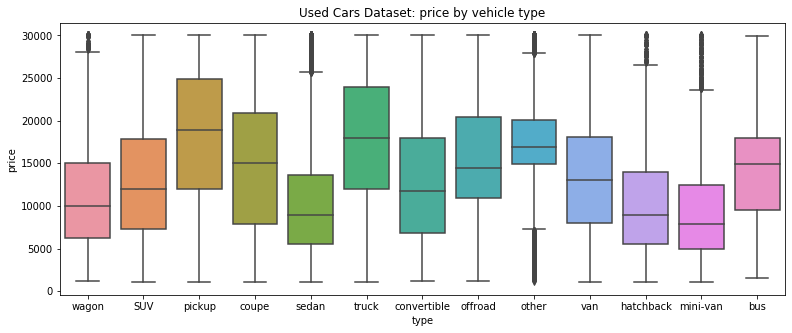

In [25]:
plt.figure(figsize=(13,5))
sns.boxplot(x='type',y='price',data=cars).set_title('Used Cars Dataset: price by vehicle type');

In [26]:
cars.type.value_counts()

sedan          57573
SUV            52793
truck          22989
pickup         22393
coupe          11464
hatchback       8727
other           7896
wagon           7390
van             5385
convertible     4342
mini-van        3828
offroad          310
bus              173
Name: type, dtype: int64

We can remove instances that do not occur very often (type `offroad` and `bus`), as well as `other`. Can also merge the `pickup` and `truck` categories into one: `pickup`. 

In [27]:
# remove type "bus","offroad","other"
cars = cars[~cars['type'].isin(['other','offroad','bus'])]
# change "truck" to "pickup"
cars['type'] = np.where(cars.type == "truck","pickup",cars.type)

In [28]:
cars.type.value_counts()

sedan          57573
SUV            52793
pickup         45382
coupe          11464
hatchback       8727
wagon           7390
van             5385
convertible     4342
mini-van        3828
Name: type, dtype: int64

## Drive Type

Now we'll look at the `drive` variable. In this case, there is a clear difference between all types and also have large number of instances, so there is no further cleaning be done in this case.

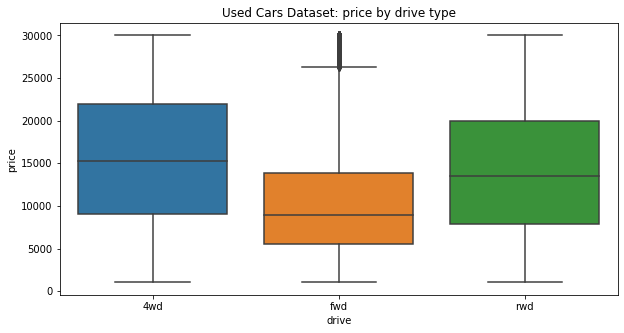

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(x='drive',y='price',data=cars).set_title('Used Cars Dataset: price by drive type');

In [30]:
cars.drive.value_counts()

4wd    83753
fwd    79820
rwd    33311
Name: drive, dtype: int64

### Data Ready for Regression Excercise
Here is what the data looks like so far (take 10 samples):

In [31]:
cars.sample(10)

,price,year,fuel,odometer,title_status,transmission,drive,type
47765,7000,2006.0,gas,152000.0,clean,automatic,4wd,pickup
363454,17995,1999.0,diesel,110295.0,clean,manual,rwd,pickup
505419,5495,2010.0,gas,150919.0,clean,automatic,rwd,wagon
120907,8995,2013.0,gas,107625.0,clean,automatic,fwd,sedan
30125,6500,2008.0,gas,139000.0,clean,automatic,rwd,coupe
390093,24999,2011.0,gas,39868.0,clean,manual,rwd,coupe
283787,8999,2007.0,gas,84573.0,clean,automatic,rwd,van
58132,18980,2014.0,gas,121596.0,clean,automatic,rwd,pickup
85288,10911,2011.0,gas,161464.0,clean,automatic,4wd,SUV
528769,5500,2010.0,gas,147792.0,clean,automatic,4wd,SUV


In [32]:
cars.shape

(196884, 8)

## Decision Tree Regression

We are now ready to predict the `price` of a vehicle using a Decision Tree Regression. First we identify the predicted variable.

In [34]:
# predicted variable
y = cars[['price']].copy()
y.head()

,price
5,12995
6,10995
10,7995
16,12995
17,12995


Now we extract the predictors (feature variables):

In [35]:
# features
X = cars.iloc[:,1:].copy()
X.head()

,year,fuel,odometer,title_status,transmission,drive,type
5,2015.0,gas,85127.0,clean,automatic,4wd,wagon
6,2014.0,gas,112383.0,clean,automatic,fwd,SUV
10,2008.0,gas,162214.0,clean,automatic,fwd,pickup
16,2009.0,gas,146353.0,clean,automatic,4wd,SUV
17,2009.0,gas,146353.0,clean,automatic,4wd,SUV


### Encode Categorical Variables

Since a Decision Tree Regressor requires numberic variables, we'll have to encode the categorical variables with `get_dummies` function from Pandas. This will make each variable either 0 or 1 at the expense of adding a large number of columns (since it will add a column or each category).

In [36]:
cat_columns = ['fuel','title_status','transmission','type','drive']
X_enc = pd.get_dummies(X,columns = cat_columns)
X_enc.sample(6)

,year,odometer,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,title_status_clean,title_status_lien,title_status_rebuilt,title_status_salvage,...,type_coupe,type_hatchback,type_mini-van,type_pickup,type_sedan,type_van,type_wagon,drive_4wd,drive_fwd,drive_rwd
286424,2015.0,26495.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
386351,2016.0,57029.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
482454,2014.0,114488.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
112489,2011.0,101023.0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
489902,2010.0,70375.0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
450662,2009.0,122598.0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [37]:
X_enc.shape

(196884, 24)

### Perform Training and Testing Split

We will split the data with 33% as test.

In [38]:
# split training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=66,test_size=0.33)

### Fit First Model

Our first Decision Tree Regressor model will be run on the default parameters that come from [SciKit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

In [39]:
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 66)
regressor.fit(X_train, y_train) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=66, splitter='best')

In [40]:
y_predicted = regressor.predict(X_test)
print('Training accuracy: ',regressor.score(X_train,y_train))
print('Test Accuracy: ',regressor.score(X_test,y_test))

Training accuracy:  0.9878322641478163
Test Accuracy:  0.7326405511046303


We see that our training accuracy is 98.8% but our testing accuracy is %73. This means that the model is overfitting the data. In order to mitigate this, I use Sklearn's Randomized Search Cross-Validataion. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn-model-selection-randomizedsearchcv) for more info.

### Hyperparameter tuning with RandomizedSearchCV

In [41]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40, 50, 60],
              "max_depth": [2, 6, 8, 12, 14],
              "min_samples_leaf": [10 ,20, 40, 100],
              }

n_iter_search = 10

rand_search_cv = RandomizedSearchCV(estimator=regressor,
                                    param_distributions= param_grid, 
                                    cv=5,
                                    n_iter=n_iter_search,
                                    n_jobs=-1)

Report scores from RandomizedSearchCV (taken from SciKit Learn [Documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py))

In [42]:
# Utility function to report best scores (taken from Skikit learn documentations)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [43]:
from time import time
start = time()

rand_search_cv.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(rand_search_cv.cv_results_)

RandomizedSearchCV took 2359.94 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.754 (std: 0.002)
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 14, 'criterion': 'mse'}

Model with rank: 2
Mean validation score: 0.753 (std: 0.001)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 12, 'criterion': 'mse'}

Model with rank: 3
Mean validation score: 0.751 (std: 0.002)
Parameters: {'min_samples_split': 40, 'min_samples_leaf': 40, 'max_depth': 14, 'criterion': 'mse'}



In [44]:
print("R-Squared::{}".format(rand_search_cv.best_score_))
print("Best Hyperparameters::\n{}".format(rand_search_cv.best_params_))

R-Squared::0.7542683305409869
Best Hyperparameters::
{'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 14, 'criterion': 'mse'}


We can see that the randomized search cross-validatio improved the model accuracy by ~2%.

### Further Improvement

Some more work is required to improve the mode accuracy. A few things that could be done:
- Trying reducing the number of levels in the categorical variables.
- Exploring a simpler multi-linear model that only uses numerical data (`price`, `odometer`, and `year`). 
- Exploring a more complex model, such as Random Forests to increase the level of accuracy.